In [13]:
import os, pickle, tqdm
#root = '/home/jhyang/WORKSPACES/MODELS/super_res/pl/s76_cvd_wse2/dbpn'
root = '/home/jhyang/WORKSPACES/MODELS/super_res/pl/s84_cvd_ws2'
for tune in os.listdir(root):
    dirs = os.listdir(os.path.join(root, tune))
    for dir in dirs:
        path_dir = os.path.join(root, tune, dir)
        if '2x' in path_dir:
            mul = '2x'
        elif '4x' in path_dir:
            mul = '4x'
        else:
            print(path_dir)
            continue
        if not os.path.isdir(os.path.join(path_dir, 'output')):
            print(path_dir)
            continue
        fns = [fn for fn in os.listdir(os.path.join(path_dir, 'output'))]
    #    for fn in fns:
        for fn in tqdm.tqdm(fns, desc=tune + ' / ' + dir):
            epoch, dset, name, sfx = fn.split('.')
            dname = '.'.join([epoch, dset])
            os.makedirs(os.path.join(path_dir, dname), exist_ok=True)
            fname = name.replace('_',f'_{mul}_') + '.txt'
            os.rename(
                os.path.join(path_dir, 'output', fn),
                os.path.join(path_dir, dname, fname)
            )

finetune / s00_2x: 100%|██████████| 24/24 [00:00<00:00, 57358.00it/s]


In [55]:
import os, pickle, tqdm
import numpy as np
#root = '/home/jhyang/WORKSPACES/MODELS/super_res/pl/s76_cvd_wse2/dbpn'
root = '/home/jhyang/WORKSPACES/MODELS/super_res/pl/s84_cvd_ws2/rbpn'
for tune in os.listdir(root):
    dirs = os.listdir(os.path.join(root, tune))
    for dir in dirs:
        path_dir = os.path.join(root, tune, dir)
        if '2x' in path_dir:
            mul = '2x'
        elif '4x' in path_dir:
            mul = '4x'
        else:
            print(path_dir)
            continue
        dns = [dn for dn in os.listdir(path_dir) if os.path.isdir(os.path.join(path_dir, dn))]
        for dn in dns:
            path_dn = os.path.join(path_dir, dn)
            for fn in os.listdir(path_dn):
                path_fn = os.path.join(path_dn, fn)
                mat = np.loadtxt(path_fn)
                if (mat.shape[1] - 1)% 3 != 0: continue
                x = mat[:, 0].reshape(-1, 1)
                ys = mat[:, 1:]
                ys = ys.reshape(x.shape[0], 3, -1)
                os.rename(path_fn, path_fn + '.bkup')
                np.savetxt(path_fn, np.hstack([x, ys[:, 0]]), fmt='%.5f')

In [54]:
x = mat[:, 0].reshape(-1,1)
ys = mat[:, 1:].reshape(x.shape[0], 3, -1)
x.shape, ys.shape
np.hstack([x, ys[:, 0]]).shape

(336, 25601)

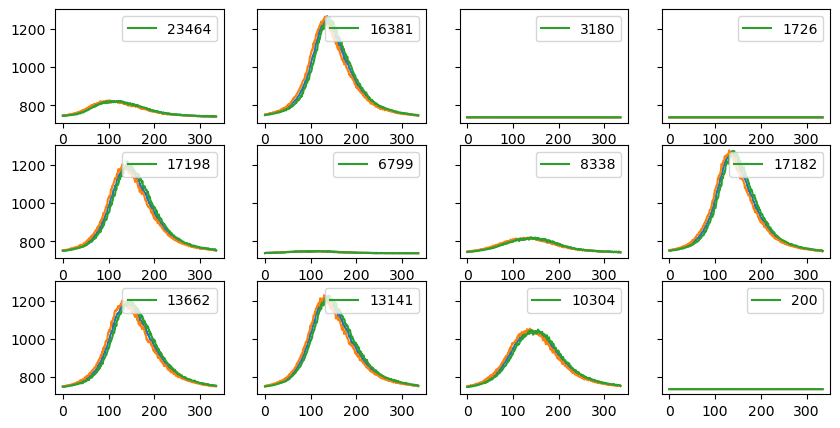

In [48]:
import matplotlib.pyplot as plt
cys = mat[:, 1:].reshape(336,3,-1)
f, axs = plt.subplots(3, 4, figsize=(10, 5), sharey=True)
idxs = np.random.randint(0, 25600, 12)
for ax, id in zip(axs.reshape(-1), idxs):
    ax.plot(cys[:,0,id])
    ax.plot(cys[:,1,id])
    ax.plot(cys[:,2,id], label=str(id))
    ax.legend(loc='upper right')

In [78]:
import sys
sys.path.append('..')
from argparse import ArgumentParser
from utils.params import Parameters
import torch, json, os
import numpy as np
from torch.utils.data import DataLoader, SubsetRandomSampler
from torch.utils.tensorboard import SummaryWriter
from utils.imagedata import SpectrumImageDataset, collate_fn
from utils.spectrum import (spectrum_psnrs, spectrum_ssims, 
                            save_spectrum, denorm_spectrum, 
                            read_spectrum, get_mask)
from utils.trainer import DBPNTrainer
from dbpn.dbpn import Net as DBPNNet
from dbpn.dbpn_v1 import Net as DBPNLLNet
from dbpn.dbpn_iterative import Net as DBPNITERNet
import gc, tqdm, time, random

param_file = 's84ft/s00_2x_all.json'
param_root = '../params_dbpn'
default_file = 'defaults2x.json'

p = Parameters(fn=param_file, root=param_root, default=default_file)

with open(p.pair_path.replace('./','../')) as f:
    pairs = json.load(f)

valid_data = SpectrumImageDataset(pairs['valid'], upscale_factor=p.upscale_factor, 
                                    root=p.data_path, data_augmentation=False,
                                    channels=p.channels, channel_stride=p.channel_stride)
valid_dl = [DataLoader(valid_data, batch_size=p.batch_size, sampler=subset, collate_fn=collate_fn) for subset in valid_data.subset_index]

if p.model_type == 'DBPNLL':
    model = DBPNLLNet(num_channels=p.channels, base_filter=64,  feat = 256, num_stages=10, scale_factor=p.upscale_factor) ###D-DBPN
elif p.model_type == 'DBPN-RES-MR64-3':
    model = DBPNITERNet(num_channels=p.channels, base_filter=64,  feat = 256, num_stages=3, scale_factor=p.upscale_factor) ###D-DBPN
else:
    model = DBPNNet(num_channels=p.channels, base_filter=64,  feat = 256, num_stages=7, scale_factor=p.upscale_factor) ###D-DBPN
    

Data generation...: 100%|██████████| 1/1 [00:01<00:00,  1.88s/it]


In [88]:
import sys
sys.path.append('..')
from argparse import ArgumentParser
from utils.params import Parameters
import torch, json, os
import numpy as np
from torch.utils.data import DataLoader, SubsetRandomSampler
from torch.utils.tensorboard import SummaryWriter
from utils.vediodata import SpectrumVedioDataset, collate_fn
from utils.spectrum import (spectrum_psnrs, spectrum_ssims, 
                            save_spectrum, denorm_spectrum, 
                            read_spectrum, get_mask)
from utils.trainer import RBPNTrainer
from rbpn.rbpn import Net as RBPN
import gc, tqdm, time, random

param_file = 's84ft/cs00_2x_all.json'
param_root = '../params_rbpn'
default_file = 'defaults2x.json'

p = Parameters(fn=param_file, root=param_root, default=default_file)

with open(p.pair_path.replace('./','../')) as f:
    pairs = json.load(f)

valid_data = SpectrumVedioDataset(pairs['valid'], upscale_factor=p.upscale_factor, 
                                  root=p.data_path, data_augmentation=False,
                                  channels=p.channels, channel_stride=p.channel_stride,
                                  num_frames=p.num_frames, frame_stride=p.frame_stride)
valid_dl = [DataLoader(valid_data, batch_size=p.batch_size, sampler=subset, collate_fn=collate_fn) for subset in valid_data.subset_index]

model = RBPN(num_channels=p.channels, base_filter=256,  feat = 64, num_stages=3, n_resblock=5, 
             nFrames=p.num_frames, scale_factor=p.upscale_factor)

100%|██████████| 1/1 [00:10<00:00, 10.05s/it]


In [90]:
outputs = {}
change = False
for i in range(0, 200, 10):
    model_path = os.path.join(p.output_path, p.tag, f'{i:05d}.model.th')
    if not os.path.isfile(model_path):
        continue
    outputs[i] = {}
    sd = {k.replace('module.',''):v for k,v in torch.load(model_path, 'cpu').items()}
    model.load_state_dict(sd)
    model.to(p.device)
    trainer = RBPNTrainer(model=model, opt=None, residual=p.residual, device=p.device)
    output = {}
    for dl in valid_dl:
        _, out = trainer.test(dl)
        output.update(out)
    legacy_path = os.path.join(p.output_path, p.tag, f'{i:05d}.valid')
    if not os.path.isdir(legacy_path):
        continue
    if change:
        os.rename(legacy_path, legacy_path + '.bkup')
    for k,v in output.items():
        pys = denorm_spectrum(v['pred'], vmin=v['vmin'], vmax=v['vmax'])
        fn = k.replace('_',f'_{p.upscale_factor}x_').replace('_None','') + '.txt'
        if not change:
            x, ys = read_spectrum(idx=fn, root=legacy_path)
            outputs[i][k] = {'l':(x, ys), 'p':(v['x'], pys)}
        else:
            save_spectrum(x = v['x'], ys=pys, fn=fn, root=legacy_path)

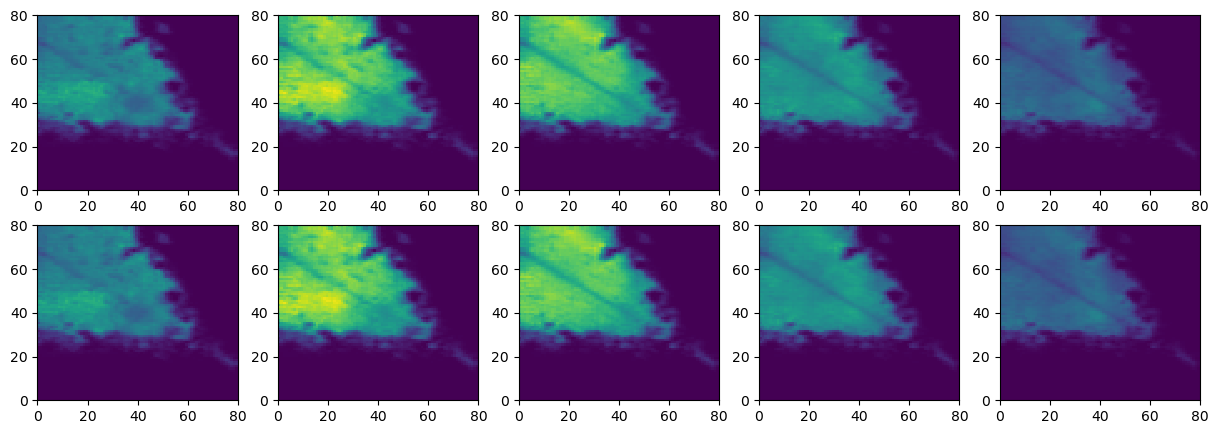

In [91]:
x1, ys1 = outputs[50]['692_694']['l']
x2, ys2 = outputs[50]['692_694']['p']

mask = get_mask(x1, x2)
mys2 = ys2[mask]

import matplotlib.pyplot as plt

idxs = 100, 125, 150, 175, 200
f, axs = plt.subplots(2, len(idxs), figsize=(15, 5))
for ax, idx in zip(axs.T, idxs):
    ax[0].pcolormesh(ys1[idx], vmin=np.min(ys2), vmax=np.max(ys2))
    ax[1].pcolormesh(mys2[idx], vmin=np.min(ys2), vmax=np.max(ys2))

In [95]:
_ys1 = ys1.reshape(335, -1).T
_ys2 = ys2.reshape(335, -1).T

In [84]:
xi, ysi = read_spectrum(692)
xt, yst = read_spectrum(694)
mask = get_mask(xi, x2)
inp = ysi[mask].reshape(np.sum(mask), -1).T
tgt = yst[mask].reshape(np.sum(mask), -1).T
pred = ys2.reshape(np.sum(mask), -1).T

In [96]:
from hdbscan import HDBSCAN, approximate_predict
model = HDBSCAN(cluster_selection_epsilon=3, prediction_data=True)
model.fit(_ys1)
label_true, _ = approximate_predict(model, _ys1)
label_pred, _ = approximate_predict(model, _ys2)

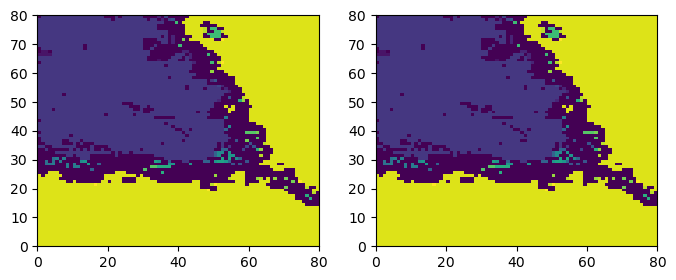

In [97]:
f, axs = plt.subplots(1, 2, figsize=(8, 3))
axs[0].pcolormesh(label_true.reshape(80,80))
axs[1].pcolormesh(label_pred.reshape(80,80))

In [98]:
r2_score(label_true, label_pred)

0.9977412957995155